In [57]:
%load_ext autoreload
%autoreload 2

import pandas as pd

from res_ind_lib import *

#Imports the function to plot render the policy experiments
from policy_assessment import *
from apply_policy import apply_policy

#ask jupyter to display the plots within this notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Baseline data and function

## parameters

In [58]:
economy = "country" #province, deparmtent
event_level = [economy, "hazard", "rp"]
infra_cats = ['transport','all_infra_but_transport']
sector_cats = ['transport','all_infra_but_transport','other_k']

## inputs

In [59]:
#Load the excel data file into a dataframe (table)
macro=pd.read_csv("intermediate/macro.csv", 
                 index_col=economy, #tells Pandas to use the first column (Provinces) as the index of the table
                ).dropna() 


# macro=def_ref_values(macro)

#Displays the first rows of that dataframe
macro.head()

macro["gdp_pc_pp_ref"] =macro["gdp_pc_pp"] 



In [60]:
cat_info = pd.read_csv("intermediate/cat_info.csv", index_col=[economy,"income_cat"])

# cat_info.v = cat_info.v.unstack().assign(poor=lambda df:df.nonpoor).stack()


cat_info.head()

n             c     axfin  gamma_SP  \
country             income_cat                                          
Albania             nonpoor     0.8  13016.935891  0.096454  1.095582   
                    poor        0.2   5055.398031  0.044618  0.617673   
Angola              nonpoor     0.8   7121.979386  0.222081  1.159988   
                    poor        0.2   1635.713147  0.040259  0.360049   
Antigua and Barbuda nonpoor     0.8  25704.504585  0.153000  1.223611   

                                           k        fa         v  shew  
country             income_cat                                          
Albania             nonpoor     70827.184540  0.025179  0.351500   0.0  
                    poor        24998.396447  0.024174  0.700000   0.0  
Angola              nonpoor     16507.539225  0.003203  0.600000   0.0  
                    poor         3636.384458  0.014163  0.700000   0.0  
Antigua and Barbuda nonpoor     64278.309421  0.203447  0.763987   0.3

In [61]:
infra_stocks = pd.read_csv("intermediate/infra_stocks_in.csv", index_col=[economy,"sector"]).dropna()
infra_stocks.sample(n=2)

,,share,v,fa
country,sector,,,
Fiji,transport,0.130303,0.243342,0.186727
Jamaica,all_infra_but_transport,0.372426,0.407671,0.140410


In [62]:
hazard_ratios = pd.read_csv("intermediate/hazard_ratios.csv", index_col=event_level+["income_cat"])

hazard_ratios.head()

fa  shew  \
country sector                  hazard     rp   income_cat                   
Albania all_infra_but_transport earthquake 20.0 nonpoor     0.007294   0.0   
                                                poor        0.007294   0.0   
        other_k                 earthquake 20.0 nonpoor     0.007294   0.0   
                                                poor        0.007294   0.0   
        transport               earthquake 20.0 nonpoor     0.007294   0.0   

                                                            share  
country sector                  hazard     rp   income_cat         
Albania all_infra_but_transport earthquake 20.0 nonpoor       NaN  
                                                poor          NaN  
        other_k                 earthquake 20.0 nonpoor       NaN  
                                                poor          NaN  
        transport               earthquake 20.0 nonpoor       NaN

In [63]:
print("macro variables are: "+", ".join(macro.columns))
print("micro variables are: "+", ".join(cat_info.columns))
print("hazard variables are: "+", ".join(hazard_ratios.columns))

macro variables are: gdp_pc_pp, pop, urbanization_rate, gdp_pc_cd, prepare_scaleup, borrow_abi, avg_prod_k, T_rebuild_K, pi, income_elast, rho, shareable, max_increased_spending, protection, tau_tax, gdp_pc_pp_ref
micro variables are: n, c, axfin, gamma_SP, k, fa, v, shew
hazard variables are: fa, shew, share


## output

In [64]:
refout = compute_resilience(macro,cat_info,infra_stocks,hazard_ratios=hazard_ratios,verbose_replace=True)
# .drop("Togo",axis=0)

Replaced in macro: 
Replaced in cats: fa, shew
Replaced in both: 


In [65]:
refout.dKtot.sum()*1e-9 , refout.dWtot_currency.sum()*1e-9

(2.763069634892683, 9.744398778914439)

## function test_package

In [66]:
def test_package(m,c,i,h,a,return_rel=False,macro=macro,hazard_ratios=hazard_ratios,cat_info=cat_info,infra_stocks=infra_stocks,refout=refout, verbose=True):
    """test a policy package where:
    -macro, cat_info and hazard_ratios, which are assumed to yield refout (all 4 optional, defautlt o baseline)
    are replaced by:
    m,c,and h. 
    This function states the difference between old and new set of params, runs the model with new set of paramters, 
    and reports difference in dW and dk"""
        
    #State differences
    if verbose:
        print("Changed in macro: "+changed_lines(m,macro))
        print("Changed in cat_info: "+changed_lines(c,cat_info))
        print("Changed in hazard: "+changed_lines(h,hazard_ratios))
        print("args: "+repr(a))

    #New outputs from new inputs
    nu = compute_resilience(m,c,i,h,**a)

    #absolute and relative difference
    delta =  refout-nu
    rel = delta/refout
    reltogdp = (delta.T/(m["gdp_pc_pp"]*m["pop"])).T
    
    #sumarizes difference in outputs
    if verbose:
        print("\nAsset losses were reduced by {dk:.1f} bn$ ({dkr:.1%} or {g:.3%} of WDP)".format(
                dk=delta.dKtot.sum()*1e-9,
                dkr=delta.dKtot.sum()/refout.dKtot.sum(),
                g = delta.dKtot.sum()/(m["gdp_pc_pp"]*m["pop"]).sum())
             )
        print("Welfare losses were reduced by {dw:.2f} bn$ ({dwr:.2%}  or {g:.3%} of WDP)".format(
                dw=delta.dWtot_currency.sum()*1e-9,
                dwr=delta.dWtot_currency.sum()/refout.dWtot_currency.sum(),
                g = delta.dWtot_currency.sum()/(m["gdp_pc_pp"]*m["pop"]).sum())
             )
    
        print("Resilience in countries changed by {dr:.2%}, from ({old:.2%} to {new:.2%} )".format(
                dr=delta.resilience.mean(),
                old=refout.resilience.mean(),
                new =nu.resilience.mean()             )
              )
        
        old=refout.dKtot.sum()/refout.dWtot_currency.sum()
        new =nu.dKtot.sum()/nu.dWtot_currency.sum()     
        print("Resilience GLOBALLY changed {d:.2%}, from ({old:.2%} to {new:.2%} )".format(
                    d=new-old,
            old=old,
            new=new)
              )
    
    
    
    #returns rel and abs difference
    if return_rel:
        return delta,rel,reltogdp,nu[["risk_to_assets","resilience","risk"]]
    
    return delta
    

# Compute policy card 

In [68]:
policy_list = ["prepare_scaleup", "borrow_abi",  "T_rebuild_K", "social_p","fap","far", "vp","kp","vr", "shew", 
               "axfin","PDSpackage","ResiliencePackage","ResiliencePlusEW","Asset_losses","Asset_losses_no_EW", "prop_nonpoor", "prop_nonpoor_lms"]

# policy_list = ["PDSpackage","ResiliencePackage","ResiliencePlusEW", "prop_nonpoor", "prop_nonpoor_lms"]



# policy_list = ["ResiliencePlusEW"]

country_list = macro.dropna().index.tolist()


pol_assess_set = ["dKtot","dWtot_currency"]

In [69]:
common_places = [c for c in macro.index if c in cat_info.index and c in hazard_ratios.index and c in infra_stocks.index]
macro = macro.ix[common_places]        
cat_info = cat_info.ix[common_places]        
hazard_ratios = hazard_ratios.ix[common_places]        
infra_stocks = infra_stocks.ix[common_places]

#initialize input (baseline inputs)
m_=macro.copy(deep=True)
c_=cat_info.copy(deep=True)
hr_ = hazard_ratios.copy(deep=True)
a_=dict(verbose_replace=True)
i_=infra_stocks.copy(deep=True)

 
#initialize outptus
delta = pd.DataFrame(index=pd.MultiIndex.from_product([country_list, pol_assess_set+["risk_to_assets","resilience","risk"]], names=[economy, 'outputs']), 
                     columns=pd.Index([],name="policies"))
rel = delta.copy()
reltogdp=  delta.copy()
nuvalues=delta.copy()
policy_description = pd.Series(index=policy_list)

#loop over policies
for pol in policy_list:
    print("\n===\npolicy: "+pol)
    m,c,hr,a,desc =apply_policy(m_,c_,hr_,a_ ,policy_name=pol)
    
    d,r,rto,nv=test_package(m,c,i_,hr,a,return_rel=True)
    
    delta[pol]= d[pol_assess_set].stack()
    rel[pol]  = r[pol_assess_set].stack()
    reltogdp[pol] = rto[pol_assess_set].stack()
    nuvalues[pol] = nv.stack()
    
    
    policy_description[pol] = desc
    
#format as renders wants it    
delta =delta.dropna().unstack()
rel =rel.dropna().unstack()
reltogdp =reltogdp.dropna().unstack()


===
policy: prepare_scaleup
Make social protection scalable after a shock
Changed in macro: prepare_scaleup (~86.7%).
Changed in cat_info: none.
Changed in hazard: none.
args: {'verbose_replace': True}
Replaced in macro: 
Replaced in cats: fa, shew
Replaced in both: 

Asset losses were reduced by -0.0 bn$ (-0.0% or -0.000% of WDP)
Welfare losses were reduced by 0.19 bn$ (1.98%  or 0.250% of WDP)
Resilience in countries changed by -0.30%, from (46.21% to 46.51% )
Resilience GLOBALLY changed 0.57%, from (28.36% to 28.93% )

===
policy: borrow_abi
Develop contingent finance and reserve funds
Changed in macro: borrow_abi (~110.2%).
Changed in cat_info: none.
Changed in hazard: none.
args: {'verbose_replace': True}
Replaced in macro: 
Replaced in cats: fa, shew
Replaced in both: 

Asset losses were reduced by 0.0 bn$ (0.0% or 0.000% of WDP)
Welfare losses were reduced by 0.49 bn$ (5.01%  or 0.630% of WDP)
Resilience in countries changed by -0.59%, from (46.21% to 46.80% )
Resilience GLOBAL

In [70]:
delta

policies         prepare_scaleup                borrow_abi                 \
outputs                    dKtot dWtot_currency      dKtot dWtot_currency   
country                                                                     
Belize              0.000000e+00   4.893215e+05        0.0   0.000000e+00   
Fiji                0.000000e+00   0.000000e+00        0.0   8.360750e+06   
Haiti              -2.384186e-07   1.746147e+08        0.0   4.525820e+08   
Jamaica             0.000000e+00   9.381430e+06        0.0   1.794235e+07   
Kiribati            0.000000e+00   0.000000e+00        0.0   0.000000e+00   
Papua New Guinea   -5.960464e-08   6.517833e+06        0.0   5.329871e+06   
Solomon Islands     0.000000e+00   1.699764e+06        0.0   2.743927e+06   
St. Lucia           0.000000e+00   4.817278e+05        0.0   7.631380e+05   
Tonga               0.000000e+00   2.261582e+05        0.0   5.953364e+05   

policies         T_rebuild_K                social_p                 \
outputs                dKtot dWtot_currency    dKtot dWtot_currency   
country                                                               
Belize                   0.0   3.759957e+07      0.0   0.000000e+00   
Fiji                     0.0   5.443549e+07      0.0   4.490892e+07   
Haiti                    0.0   3.304891e+08      0.0   2.793052e+09   
Jamaica                  0.0   1.216123e+08      0.0   4.253416e+07   
Kiribati                 0.0   2.012862e+03      0.0   2.584925e+03   
Papua New Guinea         0.0   4.445451e+07      0.0   5.872074e+07   
Solomon Islands          0.0   1.265433e+07      0.0   2.202951e+07   
St. Lucia                0.0   2.011723e+07      0.0   3.406870e+06   
Tonga                    0.0   5.538534e+06      0.0   2.642023e+06   

policies                   fap                     ...       ResiliencePlusEW  \
outputs                  dKtot dWtot_currency      ...                  dKtot   
country                                            ...                          
Belize            6.202762e+05   1.882431e+07      ...           1.318235e+07   
Fiji              9.768053e+06   6.261089e+07      ...           5.960464e-08   
Haiti             2.532723e+07   1.348473e+09      ...           4.839466e+07   
Jamaica           1.233593e+07   1.152049e+08      ...           2.586080e+07   
Kiribati          3.191447e+02   2.596895e+03      ...           2.733643e+03   
Papua New Guinea  3.829772e+06   4.894086e+07      ...           1.586148e+07   
Solomon Islands   1.702983e+06   1.815881e+07      ...           6.389339e+06   
St. Lucia         6.396262e+05   8.613351e+06      ...           3.952337e+06   
Tonga             6.401356e+05   4.526857e+06      ...           2.763934e+06   

policies                         Asset_losses                 \
outputs          dWtot_currency         dKtot dWtot_currency   
country                                                        
Belize             8.331843e+07  1.788989e+07   7.030303e+07   
Fiji               1.145530e+08  3.375615e+07   1.052163e+08   
Haiti              3.886682e+09  1.710980e+08   2.204806e+09   
Jamaica            2.752638e+08  8.282440e+07   2.466118e+08   
Kiribati           9.872114e+03  3.809845e+03   8.745490e+03   
Papua New Guinea   1.482672e+08  3.738984e+07   1.116691e+08   
Solomon Islands    5.096083e+07  1.315716e+07   4.024840e+07   
St. Lucia          3.434963e+07  7.973409e+06   2.587519e+07   
Tonga              1.392492e+07  5.864349e+06   1.281555e+07   

policies         Asset_losses_no_EW                prop_nonpoor  \
outputs                       dKtot dWtot_currency        dKtot   
country                                                           
Belize                 5.843398e+06   3.422569e+07          0.0   
Fiji                   3.375615e+07   1.052163e+08          0.0   
Haiti                  1.273821e+08   1.950242e+09          0.0   
Jamaica                5.943163e+07   2.024989e+08          0.0   
Kiribati   

In [71]:
a=pd.read_csv("intermediate/main_results.csv", index_col="country")
a.head()

big_table=pd.DataFrame(index=pd.MultiIndex.from_product([country_list, a.columns | delta.ResiliencePlusEW.columns ]))
big_table["Current"] = a.stack()

big_table["Difference"] = delta.ResiliencePlusEW.stack()

big_table["Differencerel"] =  rel.ResiliencePlusEW.stack()

big_table["With_package"] = nuvalues.ResiliencePlusEW

big_table.unstack().to_excel("results/big_table.xlsx")


big_table.Difference.unstack().describe()


,dKtot,dWtot_currency,fa,fa_in_gdp,gdp_pc_pp,pop,resilience,risk,risk_to_assets,v
count,9.000000e+00,9.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,1.293418e+07,5.119255e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.579015e+07,1.268339e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.960464e-08,9.872114e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.763934e+06,3.434963e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,6.389339e+06,8.331843e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.586148e+07,1.482672e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,4.839466e+07,3.886682e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Export excel

In [72]:
from os import makedirs
from fancy_round import fancy_round

In [73]:
makedirs("cards", exist_ok=True)

In [74]:
with pd.ExcelWriter('cards/policy_impact.xlsx') as writer:
        delta.rename(columns=policy_description).rename(columns={"dKtot":"Asset losses", "dWtot_currency":"Wellbeing losses"}
                                                       ).to_excel(writer, sheet_name="absolute (USD PPP)")

        rel.rename(columns=policy_description).rename(columns={"dKtot":"Asset losses", "dWtot_currency":"Wellbeing losses"}
                                                       ).to_excel(writer, sheet_name="relative to current losses")


In [75]:
delta.head(1)

policies prepare_scaleup                borrow_abi                T_rebuild_K  \
outputs            dKtot dWtot_currency      dKtot dWtot_currency       dKtot   
country                                                                         
Belize               0.0  489321.479583        0.0            0.0         0.0   

policies                social_p                           fap                 \
outputs  dWtot_currency    dKtot dWtot_currency          dKtot dWtot_currency   
country                                                                         
Belize     3.759957e+07      0.0            0.0  620276.211549   1.882431e+07   

policies      ...       ResiliencePlusEW                 Asset_losses  \
outputs       ...                  dKtot dWtot_currency         dKtot   
country       ...                                                       
Belize        ...           1.318235e+07   8.331843e+07  1.788989e+07   

policies                Asset_losses_no_EW                prop_nonpoor  \
outputs  dWtot_currency              dKtot dWtot_currency        dKtot   
country                                                                  
Belize     7.030303e+07       5.843398e+06   3.422569e+07          0.0   

policies                prop_nonpoor_lms                 
outputs  dWtot_currency            dKtot dWtot_currency  
country                                                  
Belize     3.031342e+06              0.0   1.855617e+06  

[1 rows x 36 columns]

In [76]:
for c in delta.index:
    x=pd.concat([1e-6*delta.ix[c].unstack()[["dWtot_currency","dKtot"]].rename(columns={"dKtot":"Asset losses m$", "dWtot_currency":"Wellbeing losses m$"}),
           100*rel.ix[c].unstack()[["dWtot_currency","dKtot"]].rename(columns={"dKtot":"Asset losses %", "dWtot_currency":"Wellbeing losses %"})],axis=1).sort_values(by="Wellbeing losses m$", 
           ascending=False).applymap(fancy_round).drop(["ResiliencePlusEW", "Asset_losses", "Asset_losses_no_EW", "ResiliencePackage","prop_nonpoor_lms","prepare_scaleup","borrow_abi"]
                                                      ).rename(index=policy_description)
    x.index.name=c
    x.to_csv("cards/country_tables/"+c+".csv"
            )

In [77]:
x

outputs,Wellbeing losses m$,Asset losses m$,Wellbeing losses %,Asset losses %
Tonga,,,,
Accelerate\nreconstruction\n(by 33%),5.50,0.00,9.50,0.00
Universal\naccess to early\nwarnings,4.80,2.80,8.20,7.70
Reduce exposure\nof the poor by 5%\nof total exposure,4.50,0.64,7.80,1.80
Increase social\ntransfers to poor\npeople to at\nleast 33%,2.60,0.00,4.50,0.00
Reduce\nexposure of the nonpoor by 5%\nof total exposure,2.50,2.10,4.30,5.80
Develop market\ninsurance\n(nonpoor people),2.00,0.00,3.40,0.00
Reduce asset\nvulnerability\n(by 30%) of\npoor people\n(5% of the population),1.50,0.19,2.50,0.53
Postdisaster\nsupport\npackage,1.30,0.00,2.20,0.00
Reduce asset\nvulnerability\n(by 30%) of\nnonpoor people\n(5% of the population),0.80,0.63,1.40,1.70


In [78]:
def f(x):
    s="{s}".format(s=fancy_round(x,2))
    if s.endswith(".0"):
        s=s[:-2]
    if s=="-0":
        s="0"
    return s    

In [79]:
for c in delta.index:

    y=1e-6*delta.ix[c].unstack()[["dWtot_currency","dKtot"]]
    x=(y.applymap(f).astype(str) 
     + ' ('+(100*rel.ix[c].unstack()[["dWtot_currency","dKtot"]]).applymap(f).astype(str)+'%)'
    )


    x=x.rename(columns={"dKtot":"Asset losses label", "dWtot_currency":"Wellbeing losses  label"}
            )

    y=y.rename(columns={"dKtot":"Asset losses value", "dWtot_currency":"Wellbeing losses value"}
            )

    idx = delta.ix[c].unstack().sort_values(by="dWtot_currency", 
              ascending=False).drop(["ResiliencePlusEW", "Asset_losses", "Asset_losses_no_EW", "ResiliencePackage","prop_nonpoor_lms","prepare_scaleup","borrow_abi"]).index


    # x=
    # x
    t = pd.concat([y,x],axis=1).ix[idx].rename(index=policy_description)
    t.index.name=c
    t.to_csv("cards/country_tables/"+c+".csv")

In [80]:
t

outputs,Wellbeing losses value,Asset losses value,Wellbeing losses label,Asset losses label
Tonga,,,,
Accelerate\nreconstruction\n(by 33%),5.538534,0.000000,5.5 (9.5%),0 (0%)
Universal\naccess to early\nwarnings,4.771007,2.763934,4.8 (8.2%),2.8 (7.7%)
Reduce exposure\nof the poor by 5%\nof total exposure,4.526857,0.640136,4.5 (7.8%),0.64 (1.8%)
Increase social\ntransfers to poor\npeople to at\nleast 33%,2.642023,0.000000,2.6 (4.5%),0 (0%)
Reduce\nexposure of the nonpoor by 5%\nof total exposure,2.524376,2.089119,2.5 (4.3%),2.1 (5.8%)
Develop market\ninsurance\n(nonpoor people),1.973107,0.000000,2 (3.4%),0 (0%)
Reduce asset\nvulnerability\n(by 30%) of\npoor people\n(5% of the population),1.471832,0.192041,1.5 (2.5%),0.19 (0.53%)
Postdisaster\nsupport\npackage,1.263995,0.000000,1.3 (2.2%),0 (0%)
Reduce asset\nvulnerability\n(by 30%) of\nnonpoor people\n(5% of the population),0.803318,0.626736,0.8 (1.4%),0.63 (1.7%)


## policy tables for Brad

In [81]:
delta.stack().columns

Index(['prepare_scaleup', 'borrow_abi', 'T_rebuild_K', 'social_p', 'fap',
       'far', 'vp', 'kp', 'vr', 'shew', 'axfin', 'PDSpackage',
       'ResiliencePackage', 'ResiliencePlusEW', 'Asset_losses',
       'Asset_losses_no_EW', 'prop_nonpoor', 'prop_nonpoor_lms'],
      dtype='object', name='policies')

In [82]:
makedirs("cards/policy_tables/", exist_ok=True)

for col in delta.stack().columns:
    y=1e-6*delta[col]
    x=(y.applymap(f).astype(str) 
     + ' ('+(100*rel[col][["dWtot_currency","dKtot"]]).applymap(f).astype(str)+'%)'
    )


    x=x.rename(columns={"dKtot":"Asset losses label", "dWtot_currency":"Wellbeing losses  label"}
            )

    x


    y=y.rename(columns={"dKtot":"Asset losses value", "dWtot_currency":"Wellbeing losses value"}
                )

    idx = delta[col].sort_values(by="dWtot_currency", 
              ascending=False).index


    t = pd.concat([y,x],axis=1).ix[idx]
    t.index.name=policy_description[col]

    t.to_csv("cards/policy_tables/"+col+".csv");
t.head(15)

outputs,Asset losses value,Wellbeing losses value,Asset losses label,Wellbeing losses label
"Develop market insurance (25% of population, only nonpoor)",,,,
Haiti,0.000000e+00,44.430094,0 (0%),44 (0.64%)
Jamaica,0.000000e+00,17.801126,0 (0%),18 (1.5%)
Papua New Guinea,-5.960464e-14,10.199908,0 (0%),10 (2.1%)
Fiji,5.960464e-14,8.106983,0 (0%),8.1 (1.3%)
Solomon Islands,0.000000e+00,2.256292,0 (0%),2.3 (1.5%)
Belize,0.000000e+00,1.855617,0 (0%),1.9 (0.86%)
St. Lucia,0.000000e+00,1.370439,0 (0%),1.4 (1.1%)
Tonga,-7.450581e-15,1.147920,0 (0%),1.1 (2%)
Kiribati,0.000000e+00,0.000530,0 (0%),0 (2.2%)


In [83]:
makedirs("cards/policy_tables_alt/", exist_ok=True)

for col in delta.stack().columns:
# for col in ["vp","vr"]:
    y=1e-6*delta[col]
    x=((100*rel[col][["dWtot_currency","dKtot"]]).applymap(f).astype(str)+"%"
     + ' ('+ y.applymap(f).astype(str) +' m$)'
    )


    x=x.rename(columns={"dKtot":"Asset losses label", "dWtot_currency":"Wellbeing losses  label"}
            )

    x


    y=y.rename(columns={"dKtot":"Asset losses value", "dWtot_currency":"Wellbeing losses value"}
                )

    idx = rel[col].sort_values(by="dWtot_currency", 
              ascending=False).index


    t = pd.concat([y,x],axis=1).ix[idx]
    t.index.name=policy_description[col]

    t.head(15).to_csv("cards/policy_tables_alt/"+col+".csv");
t

outputs,Asset losses value,Wellbeing losses value,Asset losses label,Wellbeing losses label
"Develop market insurance (25% of population, only nonpoor)",,,,
Kiribati,0.000000e+00,0.000530,0% (0 m$),2.2% (0 m$)
Papua New Guinea,-5.960464e-14,10.199908,0% (0 m$),2.1% (10 m$)
Tonga,-7.450581e-15,1.147920,0% (0 m$),2% (1.1 m$)
Solomon Islands,0.000000e+00,2.256292,0% (0 m$),1.5% (2.3 m$)
Jamaica,0.000000e+00,17.801126,0% (0 m$),1.5% (18 m$)
Fiji,5.960464e-14,8.106983,0% (0 m$),1.3% (8.1 m$)
St. Lucia,0.000000e+00,1.370439,0% (0 m$),1.1% (1.4 m$)
Belize,0.000000e+00,1.855617,0% (0 m$),0.86% (1.9 m$)
Haiti,0.000000e+00,44.430094,0% (0 m$),0.64% (44 m$)


# Render cards


In [84]:
results=pd.read_csv("results/results.csv", index_col="country")

In [85]:
#list of policy name in apply_policy we want to use here
policy_list = ["prepare_scaleup", "borrow_abi",  "T_rebuild_K", "social_p","fap","far", "vp","kp","vr", "shew", "axfin","PDSpackage","prop_nonpoor"]
# policy_list = ["fap"]

country_list = results.dropna().index
# country_list = ["Nepal", "Honduras", "Moldova", "Rwanda"]
# "Finland" in country_list

country_list

Index(['Belize', 'Fiji', 'Haiti', 'Jamaica', 'Kiribati', 'Papua New Guinea',
       'Solomon Islands', 'St. Lucia', 'Tonga'],
      dtype='object', name='country')

## colors and units

In [86]:
#list of outputs to render and color to use
colors = pd.read_csv("inputs/colors_pol_assess.csv", index_col=0)
colors

,color,edgecolor,alpha,label
dWtot_currency,#a6cee3,#1f78b4,1,Avoided well-being losses
dKtot,#cccccc,#969696,1,Avoided asset losses


## Legend

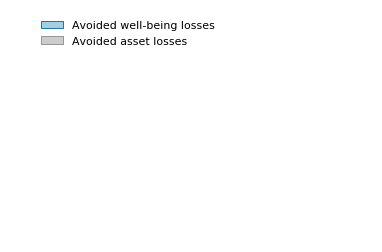

In [87]:
import matplotlib.patches as mpatches
from fancy_plots import savefig

patches=[]
for i in colors.index:
    patches+=[mpatches.Patch( 
                    fc=colors.ix[i,"color"],
                    ec= colors.ix[i,"edgecolor"],
                    label=colors.ix[i,"label"] ) ]
                        
fig=plt.figure()
ax=plt.gca()

l=ax.legend(handles=patches, loc="upper left", prop=font,frameon=False, title="")  
plt.setp(l.get_title(), multialignment='center')

ax.axis('off')

plt.savefig("cards/legend_cards.png")


## delta

### PER COUNTRY

Currently working on:  done at 2017-07-26 19:25:18.773650


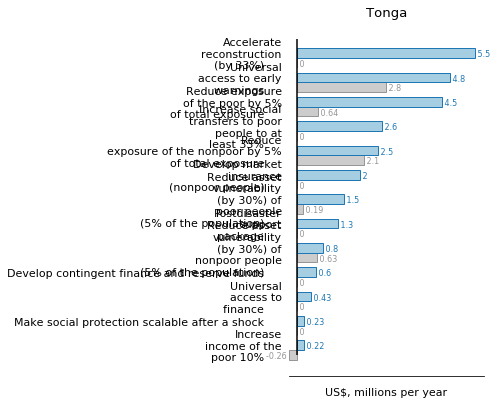

In [88]:
#unit for changes   (welfare and asset loses change)
unit = dict(multiplier = 1e-6, string = "US$, millions per year")

render_pol_cards(
    delta[policy_list],
    colors,
    policy_description,
    unit,
    
#     ["China"],
  country_list,
    outfolder="cards/country/")

### per policy

Currently working on:  done at 2017-07-26 19:30:03.759837


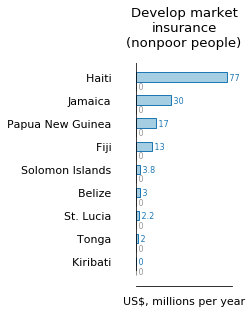

In [90]:
#unit for changes   (welfare and asset loses change)
unit = dict(multiplier = 1e-6, string = "US$, millions per year")

render_pol_cards(
    delta,
    colors,
    policy_description,
    unit,
    policy_list,
    use_title=True,
    max_lines = 15,
    outfolder="cards/policy/",
    do_by_policy=True)

## Relative to losses

### per country

Currently working on:  done at 2017-07-26 19:32:19.937584


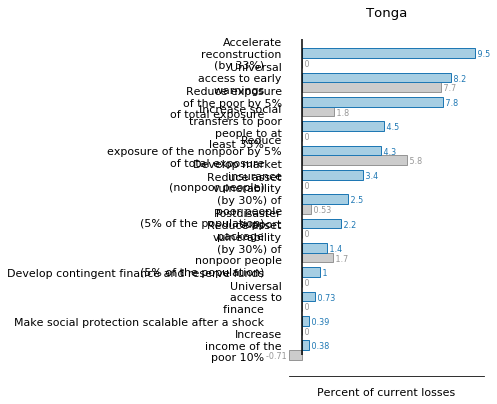

In [91]:
#unit for changes   (welfare and asset loses change)
unit = dict(multiplier = 100, string = "Percent of current losses")

render_pol_cards(
    rel[policy_list],
    colors,
    policy_description,
    unit,
    country_list, 
    name_suffix="_rel",
outfolder="cards/country/",)

### per policy

Currently working on:  done at 2017-07-26 19:32:36.118836


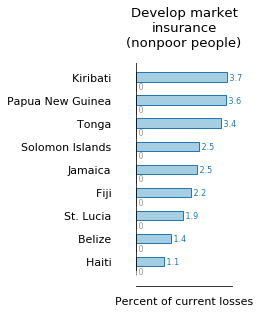

In [92]:
#unit for changes   (welfare and asset loses change)
unit = dict(multiplier = 100, string = "Percent of current losses")

render_pol_cards(
    rel,
    colors,
    policy_description,
    unit,
    policy_list,
    name_suffix="_rel",
    outfolder="cards/policy/",
    max_lines=15,
    use_title=True,
    do_by_policy=True)

## Merge all cards to single pdf

Merges the individual province cards into one big multi page pdf. Requires ghostscript.

In [ ]:
#Country cards
province_list=glob.glob("cards/country/*.pdf")
merge_cardfiles(province_list,"cards/all_country_cards.pdf")

#Policy cards
thepollist=glob.glob("cards/policy/*.pdf")
merge_cardfiles(thepollist,"cards/all_policy_cards.pdf")

Converts the pdf files to png images. Requires Imagemagick.

In [ ]:
# convert_pdf_to_png("cards/")

# Malawi single case

In [ ]:
refout_flood = compute_resilience(macro, cat_info, hazard_ratios.query("hazard=='flood'"))

In [ ]:
m,c,hr,a,desc =apply_policy(m_,c_,hr_.query("hazard=='flood'"),a_ ,policy_name="fap")

In [ ]:
d,r,rto,nv=test_package(m,c,hr,a,return_rel=True, refout=refout_flood)

In [ ]:
x=d.ix[["Malawi","Bangladesh"],["dKtot","dWtot_currency"]]*1e-6 
x

## per capita

In [ ]:
x.T/pd.Series(dict(Malawi=.16, Bangladesh=3))

In [ ]:
#just double checking the number of people
(hazard_ratios.query("hazard=='flood' & rp==100").fa*macro["pop"]).ix[["Malawi","Bangladesh"]].mean(level="country")

## discounted

In [ ]:
x.T/pd.Series(dict(Malawi=.16, Bangladesh=3))/.06